# Directed Graph Pathfinding with QAOA


Steps :
1. Write Quadratic Problem (QP) of the directed graph
1. Mapping to QUBO
1. Create ising Hamiltonien from QUBO
1. Find the smallest eigenvalue with QAOA

# Preparation


Import the necessary packages.

In [1]:
import numpy as np
import networkx as nx

Import our custom packages.

In [2]:
import sys
sys.path.insert(0, "src")
from graph_path_problem import GraphPathProblem
from qubo_util import get_qubo

## Graph creation (an example) 

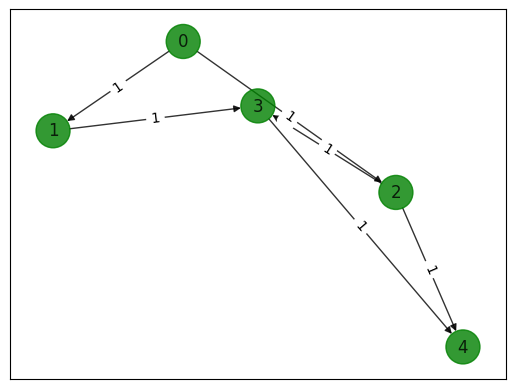

In [3]:
my_prob = GraphPathProblem()
G = my_prob.graph # Initially an empty directed graph

# Example adjacency matrix (numpy array or nested list)
adj_matrix = np.array([
    [0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
])

# Create a graph from the adjacency matrix
my_prob.graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
# Draw the graph
my_prob.draw_graph()

In [4]:
print(nx.to_numpy_array(my_prob.graph))

[[0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


In [5]:
my_prob.update_edges_register()
print(my_prob.edges_register)

bidict({(0, 1): 0, (0, 2): 1, (1, 3): 2, (2, 3): 3, (2, 4): 4, (3, 4): 5})


# Finding QUBO Matrix

The objective is to minimize the following term :
$$
H =
\underbrace{ - \delta \sum_{i,j}\omega_{i,j}x_{i,j}}_{\text{total cost (length of the sequence)}}
+ \alpha \underbrace{\sum_{i} \left( 1 - \sum_{j} x_{i,j} \right)^2}_{\text{outgoing penalty}}
+ \beta \underbrace{\sum_{j} \left( 1 - \sum_{i} x_{i,j} \right)^2}_{\text{incoming penalty}}
+ \gamma  \left(\underbrace{\sum_{i} \left( \sum_{j} x_{i,j} - \sum_{k} x_{k,i} \right)^2}_{\text{flow penalty}}
+\underbrace{\left( \sum_{j} x_{i,j} - \sum_{k} x_{k,i} - 1 \right)^2}_{\text{flow penalty (start)}}
+\underbrace{\left( \sum_{j} x_{i,j} - \sum_{k} x_{k,i} + 1 \right)^2}_{\text{flow penalty (finish)}} \right)
$$

Computing Q (You may try other coeffs : $\alpha$, $\beta$, $\gamma$ and $\delta$)

In [6]:
Q = get_qubo(my_prob, delta=1, alpha=6, beta=6, gamma=11, start=0, finish=4)
print(Q)

[[ 33.  34. -22.   0.   0.   0.]
 [ 34.  33.   0. -22. -22.   0.]
 [-22.   0.  11.  34.   0. -22.]
 [  0. -22.  34.  11.  34. -22.]
 [  0. -22.   0.  34.  33.  34.]
 [  0.   0. -22. -22.  34.  33.]]


# Solutions

## Brute force

In [7]:
# brute force with numpy
from itertools import product

def solve_qubo_bruteforce(Q,verbose=False):
    n = Q.shape[0]
    best_x = None
    best_val = np.inf

    for bits in product([0, 1], repeat=n):
        x = np.array(bits)
        val = x @ Q @ x
        if verbose:
            print(f"x = {x}, val = {val}, best_val = {best_val}, val < best_val? {val < best_val}")
        if val < best_val:
            best_val = val
            best_x = x.copy()
    return best_x, best_val

brut_solution, value = solve_qubo_bruteforce(Q)
print("Best solution:", brut_solution)
print("Objective value:", value)

Best solution: [0 1 0 1 0 1]
Objective value: -11.0


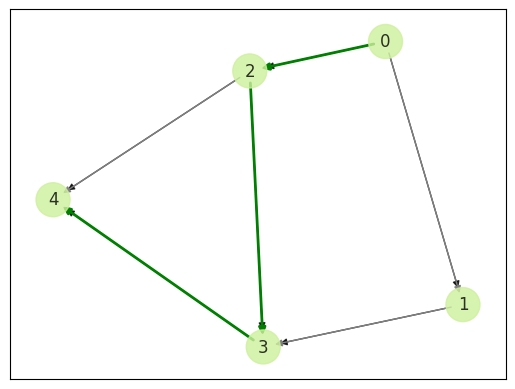

In [8]:
my_prob.show_solution(brut_solution)

## QAOA

In [9]:
from qat.opt import QUBO
# Problem setup
q_mat = -Q
problem_QUBO = QUBO(Q=q_mat, offset_q=0)
observable = problem_QUBO.get_observable("terms")
print(observable)

90.0 * I^6 +
-22.5 * (Z|[0]) +
17.0 * (ZZ|[0, 1]) +
-11.0 * (ZZ|[0, 2]) +
-11.5 * (Z|[1]) +
-11.0 * (ZZ|[1, 3]) +
-11.0 * (ZZ|[1, 4]) +
-0.5 * (Z|[2]) +
17.0 * (ZZ|[2, 3]) +
-11.0 * (ZZ|[2, 5]) +
-17.5 * (Z|[3]) +
17.0 * (ZZ|[3, 4]) +
-11.0 * (ZZ|[3, 5]) +
-39.5 * (Z|[4]) +
17.0 * (ZZ|[4, 5]) +
-11.5 * (Z|[5])


/home/ting/miniforge3/envs/ScaffoQA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final energy: 62.05485152169017
Most probable states | as bitstrings | with probability 
|010101> | 010101 | 7.03%
|101001> | 101001 | 13.09%
Best_path: 101001


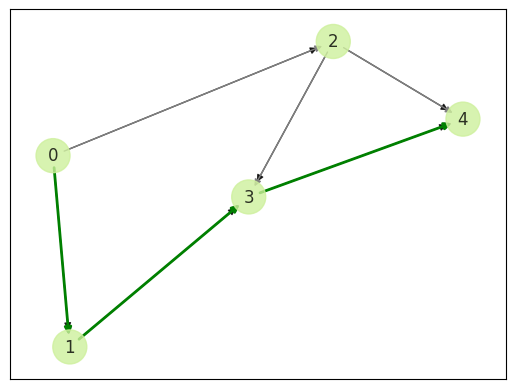

In [10]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

depth = 5 # the depth of the Ansatz
qpu = get_default_qpu()
stack = ScipyMinimizePlugin(method="COBYLA",
                            tol=1e-5,
                            options={"maxiter": 100}) | qpu
# We can directly call the to_job method of the Problem class to pack an Ansatz and
# the cost observable in a single abstract Job
job = problem_QUBO.to_job("qaoa", depth )
result = stack.submit(job)
print("Final energy:", result.value)
print("====================================================")

#Binding the variables:
sol_job = job(**eval(result.meta_data["parameter_map"]))

#Rerunning in 'SAMPLE' mode to get the most probable states:
sampling_job = sol_job.circuit.to_job(nbshots=1024)

sol_res = qpu.submit(sampling_job)
print("Most probable states | as bitstrings | with probability ")
for sample in sol_res:
    if sample.probability > 0.05:
        print(f"{sample.state} | {sample.state.value[0]} | {100 * sample.probability:.2f}%")
print("====================================================")

best_path = max([(s.state.value[0], s.probability) for s in sol_res], key=lambda s: s[1])[0]
print(f"Best_path: {best_path}")
my_prob.show_solution(best_path)